https://data.caltech.edu/records/20098

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time


In [61]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [62]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
ROOT = '../../../../../DataSets/'

In [63]:
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [64]:


if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:

    class_dir = os.path.join(images_dir, c)

    images = os.listdir(class_dir)

    n_train = int(len(images) * TRAIN_RATIO)

    train_images = images[:n_train]
    test_images = images[n_train:]

    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        shutil.copyfile(image_src, image_dst)

    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image)
        shutil.copyfile(image_src, image_dst)


In [65]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim=(1, 2))
    stds += torch.std(img, dim=(1, 2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


Calculated means: tensor([0.4862, 0.4999, 0.4315])
Calculated stds: tensor([0.1821, 0.1811, 0.1931])


In [66]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(pretrained_size, padding=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means,
                         std=pretrained_stds)
])


In [67]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)


In [68]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])


In [69]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms


In [70]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


In [71]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)


In [72]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


In [73]:
def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')


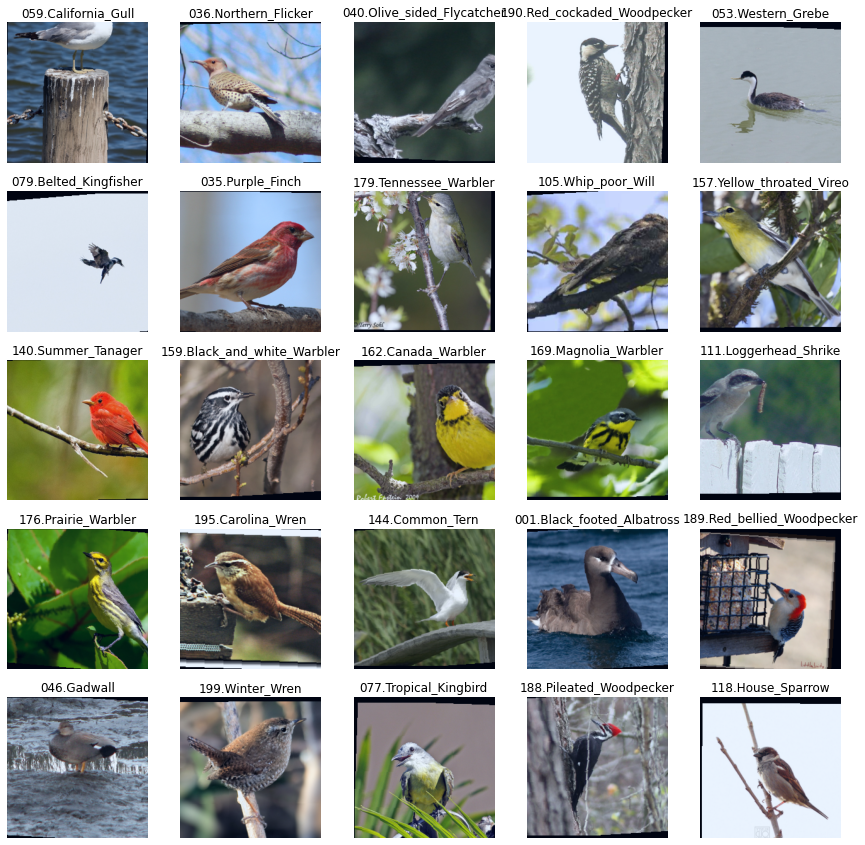

In [74]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)


In [75]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label


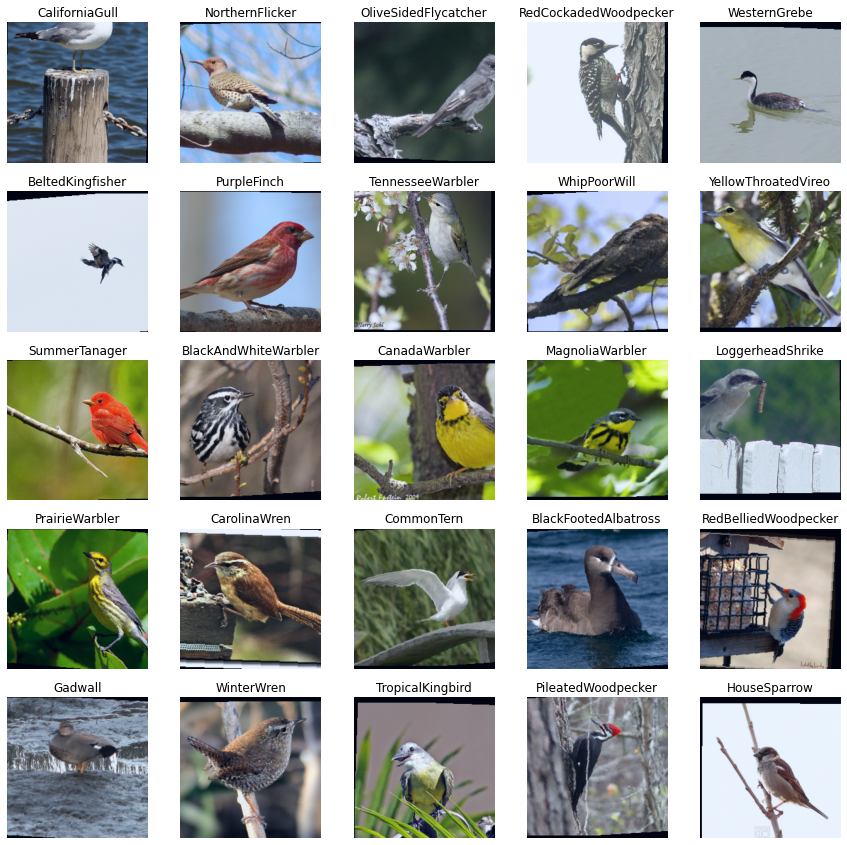

In [76]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)


In [77]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels,
                               kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(
            block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(
            block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(
            block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h


In [78]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                             stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x


In [79]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])


In [80]:
resnet18_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[2, 2, 2, 2],
                               channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])


In [81]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                               stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1,
                               stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1,
                             stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x


In [82]:
resnet50_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 128, 256, 512])

resnet101_config = ResNetConfig(block=Bottleneck,
                                n_blocks=[3, 4, 23, 3],
                                channels=[64, 128, 256, 512])

resnet152_config = ResNetConfig(block=Bottleneck,
                                n_blocks=[3, 8, 36, 3],
                                channels=[64, 128, 256, 512])


In [83]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, layers, channels = config
        self.in_channels = channels[0]

        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])

        self.conv1 = nn.Conv2d(3, self.in_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(
            block, layers[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(
            block, layers[2], channels[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1):

        layers = []

        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h


In [84]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)


class CIFARBasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        if downsample:
            def identity_fn(x): return F.pad(x[:, :, ::2, ::2],
                                             [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x


In [85]:
cifar_resnet20_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[3, 3, 3],
                                     channels=[16, 32, 64])

cifar_resnet32_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[5, 5, 5],
                                     channels=[16, 32, 64])

cifar_resnet44_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[7, 7, 7],
                                     channels=[16, 32, 64])

cifar_resnet56_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[9, 9, 9],
                                     channels=[16, 32, 64])

cifar_resnet110_config = ResNetConfig(block=CIFARBasicBlock,
                                      n_blocks=[18, 18, 18],
                                      channels=[16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block=CIFARBasicBlock,
                                       n_blocks=[20, 20, 20],
                                       channels=[16, 32, 64])


In [86]:
pretrained_model = models.resnet50(pretrained=True)


In [87]:
print(pretrained_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [88]:
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)


In [89]:
pretrained_model.fc = fc


In [90]:
model = ResNet(resnet50_config, OUTPUT_DIM)


In [91]:
model.load_state_dict(pretrained_model.state_dict())


<All keys matched successfully>

In [92]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 23,917,832 trainable parameters


In [93]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.45 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)


In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()
